In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.linalg

sns.set_style("whitegrid")

### Coefficients

In [2]:
y = .5  # persistence of technology LOM
g = .1
beta = .99
alpha = 0
gamma = 0

### Steady State Variables

*In the following variable names: 'ss' ~ 'steady state'.*

In [3]:
ss_return = 1 / beta
ss_consum = y - g

rho_1 = (-beta**2 * ss_consum * alpha) / (1-beta)**2 + ss_consum / (1-beta) + 1 / beta
rho_2 = (ss_consum * alpha) / (ss_return-1)**2 - alpha
rho_3 = -ss_consum * beta**2 / (1-beta)**2
rho_4 = ss_consum * beta**2 / (1-beta)**2 - 1

tmp0 = (gamma - 1 / beta)
tmp1 = tmp0 * rho_3 - rho_4
tmp2 = tmp0 * rho_1 - rho_2

### Dynamic System

*The matrices can be constructed in a similar fashion as on the last problem set.*

In [4]:
A = np.array([ 
    [1, rho_1, 0, 0],
    [0, 1    , 0, 0],
    [0, 0    , 1, 0],
    [0, 0    , 0, 1],
])

B = np.array([
    [-tmp0, -rho_2    , tmp1          , tmp2      ],
    [0    , alpha*beta, beta          , alpha*beta],
    [0    , 0         , 0             , 0         ],
    [0    , 0         , rho_3 / rho_1 , 1         ],
])

C = np.array([tmp0, 0, 0, 0])

In the function ``scipy.linalg.ordqz`` I set ``sort="ouc"`` which stands for outside unit circle. This achieves the desired order for our problem. *(Here I am reusing the code written for the 4th problem set; see [here](https://nbviewer.jupyter.org/github/timmens/macro_problems/blob/main/ps4.ipynb?flush_cache=True).)*

In [5]:
S, T, _, _, Q, Z =  scipy.linalg.ordqz(A, B, sort="ouc")

In [6]:
eigen_values = np.diag(T) / np.diag(S)
eigen_values = np.round(eigen_values, decimals=15)

I = np.where(np.abs(eigen_values) < 1)[0]

ns = len(I)

S_11, T_11, Z_11 = (m[:ns, :ns] for m in (S, T, Z))
Z_21 = Z[ns:, :ns]

Z_11_inverse = np.linalg.inv(Z_11)

In [7]:
S2S = Z_11 @ np.linalg.inv(S_11) @ T_11 @ np.linalg.inv(Z_11) # states to states
S2C = Z_21 @ np.linalg.inv(Z_11)                              # states to controls

### Actual Computation of the Impulse Response

In [8]:
n_periods = 5
state = np.array([39, 5])
result = np.empty((n_periods, 4))

In [9]:
for t in range(n_periods):
    controls = S2C @ state
    updated_state = S2S @ state
    result[t, :2] = updated_state
    result[t, 2:4] = controls
    state = updated_state

### Plotting

*The result seems false but I do not know how to fix it at the moment.*

In [10]:
df = pd.DataFrame(
    result[:, :3],
    columns=["debt", "inflation", "monetary_shock"],
    index=np.arange(n_periods)
)
df.index.name = "periods"
df = df.reset_index().melt(id_vars="periods", var_name="variable")

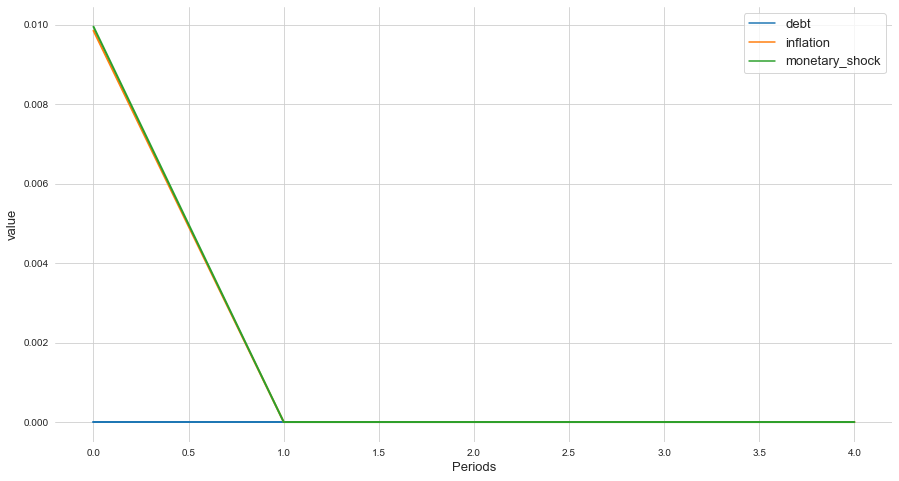

In [11]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 8)

sns.lineplot(
    x="periods",
    y="value",
    data=df,
    hue="variable",
    legend="brief",
    linewidth=2,
    ax=ax,
)

ax.set(xlabel="Periods")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
plt.legend(prop={'size': 13})
plt.show()